### Neural Style Transfer

In [0]:
import tensorflow as tf
import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image 
import time
import functools

In [3]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')

# https://commons.wikimedia.org/wiki/File:Vassily_Kandinsky,_1913_-_Composition_7.jpg
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

196608/195196 [==============================] - 0s 0us/step


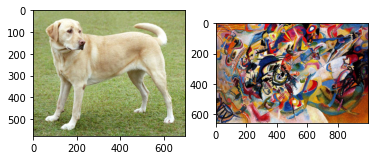

In [4]:
plt.subplot(1,2,1)
img = plt.imread(content_path)
plt.imshow(img, label = 'Content Image')

plt.subplot(1,2,2)
img = plt.imread(style_path)
plt.imshow(img, label = 'Style Image')

In [0]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels = 3, dtype = tf.float32)
  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim/long_dim
  new_shape = tf.cast(scale*shape, tf.int32)
  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis,:]
  return img

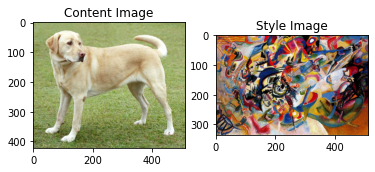

In [6]:
def imshow(img, title = None):
  img = tf.squeeze(img, axis = 0)
  plt.imshow(img)
  if title:
    plt.title(title)
plt.subplot(1,2,1)
imshow(load_img(content_path), 'Content Image')
content_image = load_img(content_path)

plt.subplot(1,2,2)
imshow(load_img(style_path), 'Style Image')
style_image = load_img(style_path)

In [7]:
import tensorflow_hub as hub
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
#tensor_to_image(stylized_image)
print(stylized_image)

tf.Tensor(
[[[[0.9163163  0.91670376 0.9520228 ]
   [0.49658465 0.5630517  0.65032214]
   [0.47130492 0.54730415 0.6932507 ]
   ...
   [0.64519143 0.17506021 0.67549455]
   [0.6744871  0.16917974 0.7092856 ]
   [0.65555745 0.14101037 0.6934416 ]]

  [[0.5736093  0.61455035 0.7274949 ]
   [0.11108997 0.16404125 0.21524736]
   [0.13129625 0.19376466 0.30399343]
   ...
   [0.5271356  0.1160903  0.5640041 ]
   [0.527454   0.09956923 0.5732395 ]
   [0.4867499  0.07847807 0.54295194]]

  [[0.60525525 0.6201947  0.74285305]
   [0.14367005 0.18700531 0.24737522]
   [0.18489704 0.24598    0.3546207 ]
   ...
   [0.6392749  0.16846102 0.62766737]
   [0.6285181  0.14040288 0.6289294 ]
   [0.5900349  0.11082664 0.5937766 ]]

  ...

  [[0.6696092  0.28705728 0.8330885 ]
   [0.4075013  0.14619389 0.60586834]
   [0.50211954 0.18622932 0.69245607]
   ...
   [0.82797384 0.358603   0.7523767 ]
   [0.8205229  0.39074355 0.76889455]
   [0.77040637 0.34158492 0.7368233 ]]

  [[0.6775772  0.24025288 0.852881

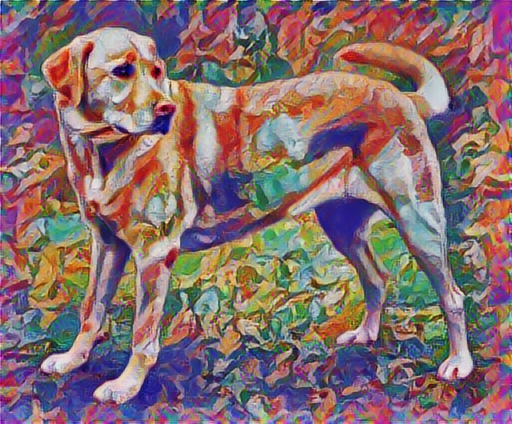

In [8]:
def tensor_to_img(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype = np.uint8)
  if tensor.ndim > 3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)
  
tensor_to_img(stylized_image)

In [45]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224,224))
vgg = tf.keras.applications.VGG19(include_top = True, weights = 'imagenet')
out = vgg(x)
predict_top5 = tf.keras.applications.vgg19.decode_predictions(out.numpy(), top=5)[0]
[print(name,prob) for (num,name,prob) in predict_top5]


Labrador_retriever 0.49317285
golden_retriever 0.23665173
kuvasz 0.03635726
Chesapeake_Bay_retriever 0.024182761
Greater_Swiss_Mountain_dog 0.018646063


[None, None, None, None, None]

In [46]:
vgg = tf.keras.applications.VGG19(include_top=False, weights = 'imagenet')
for layer in vgg.layers:
  print(layer.name)

input_8
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [0]:
content_layers = ['block5_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [0]:
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False, weights = 'imagenet')
  vgg.trainable = False
  outputs = [vgg.get_layer(name).output for name in layer_names]
  model = tf.keras.Model([vgg.input], outputs)
  return model

In [49]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

for name,output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 336, 512, 64)
  min:  0.0
  max:  835.5255
  mean:  33.97525

block2_conv1
  shape:  (1, 168, 256, 128)
  min:  0.0
  max:  4625.887
  mean:  199.82687

block3_conv1
  shape:  (1, 84, 128, 256)
  min:  0.0
  max:  8789.24
  mean:  230.78099

block4_conv1
  shape:  (1, 42, 64, 512)
  min:  0.0
  max:  21566.135
  mean:  791.24005

block5_conv1
  shape:  (1, 21, 32, 512)
  min:  0.0
  max:  3189.2537
  mean:  59.179478



In [0]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_tensor.shape[1]*input_tensor.shape[2], tf.float32)
  return result/num_locations

In [0]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel,self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.vgg.trainable = False
    self.num_style_layers = len(style_layers)

  def call(self,inputs):
    inputs = inputs*255
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    out = self.vgg(preprocessed_input)
    style_out = out[:self.num_style_layers]
    content_out = out[self.num_style_layers:]
    style_gram = [gram_matrix(out) for out in style_out]
    style_dict = {name:value for name,value in zip(self.style_layers,style_gram)}
    content_dict = {name:value for name ,value in zip(self.content_layers,content_out)}
    return {'style':style_dict, 'content':content_dict}


In [52]:
extractor = StyleContentModel(style_layers, content_layers)
results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0055228495
    max:  28014.562
    mean:  263.79022

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  61479.484
    mean:  9100.949

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  545623.4
    mean:  7660.976

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  4320501.0
    mean:  134288.86

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  110005.37
    mean:  1487.0378

Contents:
   block5_conv2
    shape:  (1, 26, 32, 512)
    min:  0.0
    max:  2410.8794
    mean:  13.764149


In [68]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']
style_outputs = extractor(image)
print(style_targets)
print(style_outputs)

{'block1_conv1': <tf.Tensor: shape=(1, 64, 64), dtype=float32, numpy=
array([[[ 5166.2417 ,   605.19324,   824.5504 , ...,  1739.0223 ,
          1467.1721 ,  2504.0796 ],
        [  605.19324,  1162.9896 ,   597.4761 , ...,   518.7834 ,
           403.55716,   503.52985],
        [  824.5504 ,   597.4761 ,   635.4706 , ...,   100.54668,
           615.1243 ,   898.81714],
        ...,
        [ 1739.0223 ,   518.7834 ,   100.54668, ..., 11164.051  ,
          1034.8024 ,   778.8619 ],
        [ 1467.1721 ,   403.55716,   615.1243 , ...,  1034.8024 ,
          2300.4683 ,  2206.1816 ],
        [ 2504.0796 ,   503.52985,   898.81714, ...,   778.8619 ,
          2206.1816 ,  2829.5215 ]]], dtype=float32)>, 'block2_conv1': <tf.Tensor: shape=(1, 128, 128), dtype=float32, numpy=
array([[[1.5257654e+03, 2.3076326e+02, 1.5033583e+01, ...,
         1.5111443e+03, 1.0906848e+03, 5.0436639e+02],
        [2.3076326e+02, 5.0887328e+04, 2.3263078e+04, ...,
         5.1740156e+04, 3.1996410e+04, 2.6

In [0]:

image = tf.Variable(content_image)

opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

style_weight = 1e-2
content_weight = 1e4

def clip_0_1(image):
  return tf.clip_by_value(image,clip_value_min=0.0,clip_value_max=1.0)

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [0]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += 30 * tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

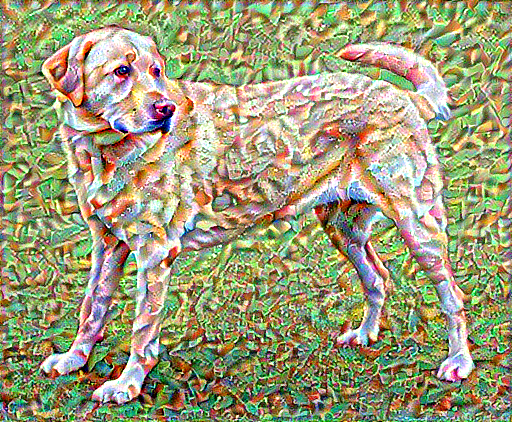

In [79]:
train_step(image)
train_step(image)
train_step(image)

tensor_to_img(image)

In [0]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))

...................................